In [1]:
import sys
sys.path.append("/home/twhit/smcdet/")

from utils.misc import select_cuda_device
device = select_cuda_device()

Selected device 0, which has 10822 MB available.


In [2]:
import torch
import torch.nn.functional as F
from torch.distributions import Poisson, Categorical, Normal, MixtureSameFamily, LogNormal

from scipy.stats import truncpareto, lognorm
from sklearn.mixture import GaussianMixture

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import pickle

from hydra import initialize, compose
from hydra.utils import instantiate

from astropy.io import fits
from astropy.wcs import WCS

from experiments.m71.survey_utils.catalog import FullCatalog

from utils.sdss import convert_mag_to_nmgy, convert_nmgy_to_mag

from smcdet.images import M71ImageModel

from einops import rearrange

In [3]:
with initialize(config_path=".", version_base=None):
    cfg = compose(config_name="config")

---

### **SDSS image**

In [4]:
sdss = instantiate(cfg.surveys.sdss)
sdss.prepare_data()

In [5]:
field52_rband_fits = fits.open('/data/scratch/twhit/m71/6895/3/52/frame-r-006895-3-0052.fits')
field52_rband_wcs = WCS(field52_rband_fits[0].header)

# We will catalog a 320x160 pixel region with lower left corner at (1728, 900)
field52_rband_wcs.pixel_to_world(1728, 900)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<SkyCoord (ICRS): (ra, dec) in deg
    (298.40759022, 18.78339333)>

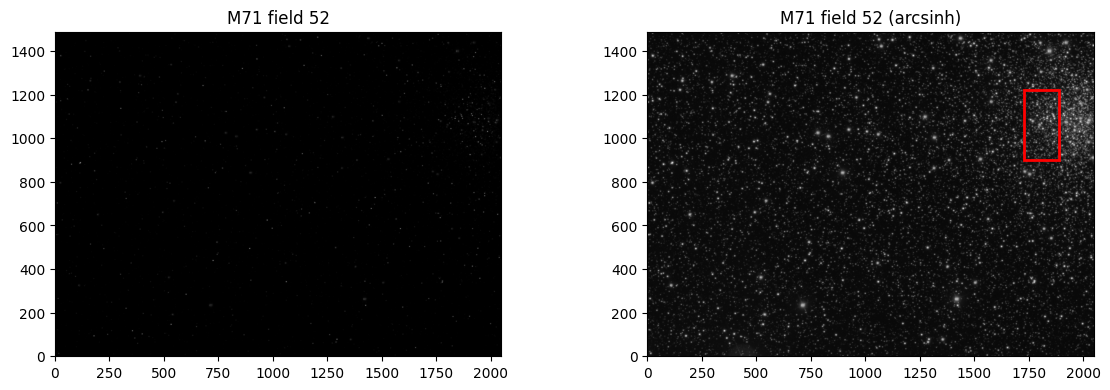

In [6]:
wholefield_nmgy = field52_rband_fits[0].data # image in nmgy

wholefield_nelec = sdss[0]['image'][2] # image in num electrons

wholefield_background_nelec = sdss[0]['background'][2] # background in num electrons

# sdss conversion factors
gain = sdss[0]['gain'][2]
wholefield_nelec_per_nmgy = sdss[0]['flux_calibration'][2]
wholefield_adu_per_nmgy = wholefield_nelec_per_nmgy / gain

wholefield_adu = wholefield_nelec / gain # image in adu
wholefield_adu_arcsinh = np.arcsinh(wholefield_adu)

wholefield_background_adu = wholefield_background_nelec / gain

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
rect = Rectangle((1728, 900), 160, 320, linewidth=2, edgecolor='r', facecolor='none')

_ = ax[0].imshow(wholefield_adu, origin='lower', cmap='gray')
_ = ax[0].set_title('M71 field 52')

_ = ax[1].imshow(wholefield_adu_arcsinh, origin='lower', cmap='gray')
_ = plt.gca().add_patch(rect)
_ = ax[1].set_title('M71 field 52 (arcsinh)')

_ = fig.tight_layout()

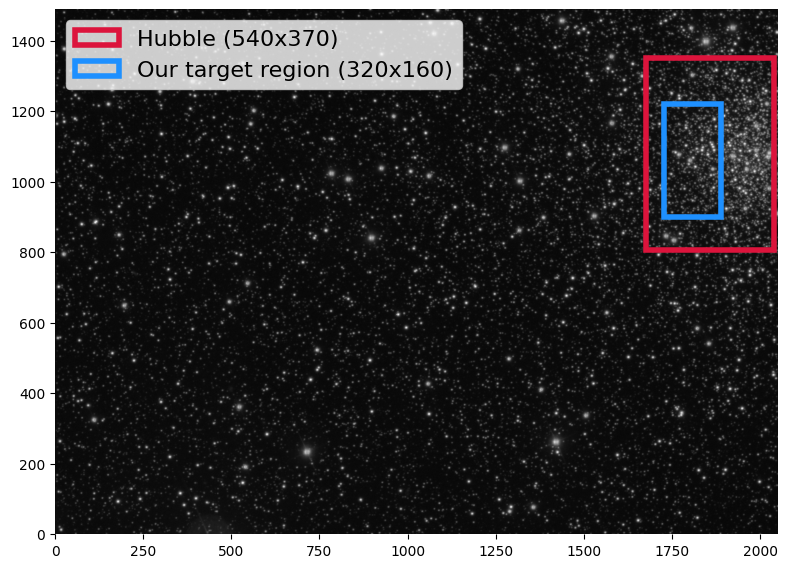

In [7]:
# save the arcsinh image
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

hubble_rect = Rectangle((1675, 807), 365, 544, linewidth = 4, edgecolor = 'crimson', facecolor = 'none', label = "Hubble (540x370)")
our_region = Rectangle((1728, 900), 160, 320, linewidth = 4, edgecolor = 'dodgerblue', facecolor = 'none', label = "Our target region (320x160)")
_ = ax.imshow(wholefield_adu_arcsinh, origin='lower', cmap='gray')
_ = plt.gca().add_patch(hubble_rect)
_ = plt.gca().add_patch(our_region)
_ = ax.legend(fontsize = 16, markerscale = 4, facecolor = 'white')
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

fig.tight_layout()

fig.savefig('results/figures/m71_target_region.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

---

### **Hubble catalog**

All magnitudes and fluxes are in the r-band.

In [8]:
# wget https://archive.stsci.edu/pub/hlsp/acsggct/ngc6838/hlsp_acsggct_hst_acs-wfc_ngc6838_r.rdviq.cal.adj.zpt

hubble_catalog = np.loadtxt('/data/scratch/twhit/m71/hlsp_acsggct_hst_acs-wfc_ngc6838_r.rdviq.cal.adj.zpt',
                            skiprows = 3, usecols=(9, 21, 22))

In [9]:
fluxes_all = convert_mag_to_nmgy(torch.from_numpy(hubble_catalog[:,0]))
mags_all = convert_nmgy_to_mag(fluxes_all)

ra_all = torch.from_numpy(hubble_catalog[:,1])
dec_all = torch.from_numpy(hubble_catalog[:,2])

locs_all = FullCatalog.plocs_from_ra_dec(ra_all, dec_all, field52_rband_wcs)

In [10]:
locs_mask = (locs_all[:,0] > 900) & (locs_all[:,0] < 1220)
locs_mask &= (locs_all[:,1] > 1728) & (locs_all[:,1] < 1888)

locs = locs_all[locs_mask]
locs -= torch.tensor([900.0, 1728.0])
mags = mags_all[locs_mask]
fluxes = fluxes_all[locs_mask]

In [11]:
mag_upper_bound = 24.0

mag_mask = mags < mag_upper_bound

locs_magcut = locs[mag_mask]
mags_magcut = mags[mag_mask]
fluxes_magcut = fluxes[mag_mask]

---

### **Store image tiles and tile catalogs**

In [12]:
tile_dim = 8
max_objects_per_tile = 60
pad = 4

# Subset to the 320x160 pixel region and partition it into 8x8 pixel tiles
image_nmgy = torch.from_numpy(wholefield_nmgy[900:1220, 1728:1888].astype(np.float32))
tiles_nmgy = image_nmgy.unfold(0, tile_dim, tile_dim).unfold(1, tile_dim, tile_dim)
image_nelec = torch.from_numpy(wholefield_nelec[900:1220, 1728:1888].astype(np.float32))
tiles_nelec = image_nelec.unfold(0, tile_dim, tile_dim).unfold(1, tile_dim, tile_dim)
image_adu = torch.from_numpy(wholefield_adu[900:1220, 1728:1888].astype(np.float32))
tiles_adu = image_adu.unfold(0, tile_dim, tile_dim).unfold(1, tile_dim, tile_dim)

In [13]:
tile_unpruned_counts = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1])
tile_unpruned_locs = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1], max_objects_per_tile, 2)
tile_unpruned_mags = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1], max_objects_per_tile)
tile_unpruned_fluxes = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1], max_objects_per_tile)

tile_pruned_counts = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1])
tile_pruned_locs = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1], max_objects_per_tile, 2)
tile_pruned_mags = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1], max_objects_per_tile)
tile_pruned_fluxes = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1], max_objects_per_tile)

tile_unpruned_counts_magcut = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1])
tile_unpruned_locs_magcut = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1], max_objects_per_tile, 2)
tile_unpruned_mags_magcut = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1], max_objects_per_tile)
tile_unpruned_fluxes_magcut = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1], max_objects_per_tile)

tile_pruned_counts_magcut = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1])
tile_pruned_locs_magcut = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1], max_objects_per_tile, 2)
tile_pruned_mags_magcut = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1], max_objects_per_tile)
tile_pruned_fluxes_magcut = torch.zeros(tiles_adu.shape[0], tiles_adu.shape[1], max_objects_per_tile)

for h in range(tiles_adu.shape[0]):
    for w in range(tiles_adu.shape[1]):
        # unpruned
        unpruned_locs_mask = torch.logical_and(
            locs > torch.tensor([h,w]) * tile_dim - pad,
            locs < torch.tensor([h+1,w+1]) * tile_dim + pad
        ).all(-1)
        tile_unpruned_counts[h,w] = unpruned_locs_mask.sum()
        tile_unpruned_locs[h,w,:tile_unpruned_counts[h,w].int()] = (locs - torch.tensor([h,w]) * tile_dim)[unpruned_locs_mask]
        tile_unpruned_mags[h,w,:tile_unpruned_counts[h,w].int()] = mags[unpruned_locs_mask]
        tile_unpruned_fluxes[h,w,:tile_unpruned_counts[h,w].int()] = fluxes[unpruned_locs_mask]
        
        # pruned
        pruned_locs_mask = torch.logical_and(
            locs > torch.tensor([h,w]) * tile_dim,
            locs < torch.tensor([h+1,w+1]) * tile_dim
        ).all(-1)
        tile_pruned_counts[h,w] = pruned_locs_mask.sum()
        tile_pruned_locs[h,w,:tile_pruned_counts[h,w].int()] = (locs - torch.tensor([h,w]) * tile_dim)[pruned_locs_mask]
        tile_pruned_mags[h,w,:tile_pruned_counts[h,w].int()] = mags[pruned_locs_mask]
        tile_pruned_fluxes[h,w,:tile_pruned_counts[h,w].int()] = fluxes[pruned_locs_mask]
        
        # unpruned magcut
        unpruned_locs_magcut_mask = torch.logical_and(
            locs_magcut > torch.tensor([h,w]) * tile_dim - pad,
            locs_magcut < torch.tensor([h+1,w+1]) * tile_dim + pad
        ).all(-1)
        tile_unpruned_counts_magcut[h,w] = unpruned_locs_magcut_mask.sum()
        tile_unpruned_locs_magcut[h,w,:tile_unpruned_counts_magcut[h,w].int()] = (locs_magcut - torch.tensor([h,w]) * tile_dim)[unpruned_locs_magcut_mask]
        tile_unpruned_mags_magcut[h,w,:tile_unpruned_counts_magcut[h,w].int()] = mags_magcut[unpruned_locs_magcut_mask]
        tile_unpruned_fluxes_magcut[h,w,:tile_unpruned_counts_magcut[h,w].int()] = fluxes_magcut[unpruned_locs_magcut_mask]
        
        # pruned magcut
        pruned_locs_magcut_mask = torch.logical_and(
            locs_magcut > torch.tensor([h,w]) * tile_dim,
            locs_magcut < torch.tensor([h+1,w+1]) * tile_dim
        ).all(-1)
        tile_pruned_counts_magcut[h,w] = pruned_locs_magcut_mask.sum()
        tile_pruned_locs_magcut[h,w,:tile_pruned_counts_magcut[h,w].int()] = (locs_magcut - torch.tensor([h,w]) * tile_dim)[pruned_locs_magcut_mask]
        tile_pruned_mags_magcut[h,w,:tile_pruned_counts_magcut[h,w].int()] = mags_magcut[pruned_locs_magcut_mask]
        tile_pruned_fluxes_magcut[h,w,:tile_pruned_counts_magcut[h,w].int()] = fluxes_magcut[pruned_locs_magcut_mask]

In [14]:
checkerboard_mask = torch.tensor([[((h + w) % 2 == 0) for w in range(tiles_nelec.shape[1])] for h in range(tiles_nelec.shape[0])])

In [15]:
# in SDSS, stars with a magnitude smaller than 14.0 are saturated
saturation_mask = (tile_pruned_fluxes > convert_mag_to_nmgy(torch.tensor(14.0))).any(-1)

kernel = torch.ones((1, 1, 7, 7))

saturation_mask_with_neighbors = F.conv2d(
    saturation_mask.unsqueeze(0).unsqueeze(0).float(), kernel, padding = 3
).squeeze() > 0

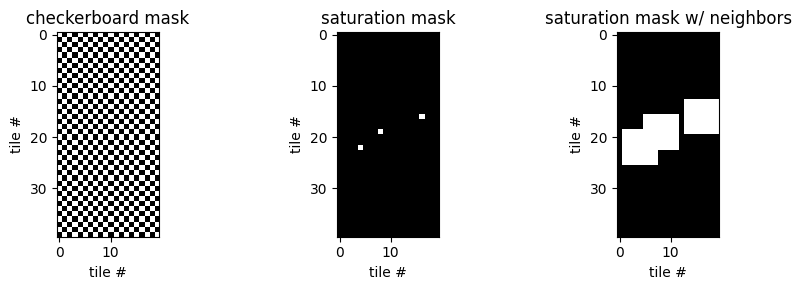

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (9, 3))
_ = ax[0].imshow(checkerboard_mask, cmap = 'gray')
_ = ax[0].set_title('checkerboard mask')
_ = ax[1].imshow(saturation_mask, cmap = 'gray')
_ = ax[1].set_title('saturation mask')
_ = ax[2].imshow(saturation_mask_with_neighbors, cmap = 'gray')
_ = ax[2].set_title('saturation mask w/ neighbors')

for a in ax.flat:
    a.set_xlabel('tile #')
    a.set_ylabel('tile #')

fig.tight_layout()

In [17]:
torch.save(tiles_adu[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/tiles.pt')

# pruned
torch.save(tile_pruned_counts[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/pruned_counts.pt')
torch.save(tile_pruned_locs[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/pruned_locs.pt')
torch.save(tile_pruned_mags[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/pruned_mags.pt')
torch.save(tile_pruned_fluxes[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/pruned_fluxes.pt')

# unpruned
torch.save(tile_unpruned_counts[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/unpruned_counts.pt')
torch.save(tile_unpruned_locs[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/unpruned_locs.pt')
torch.save(tile_unpruned_mags[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/unpruned_mags.pt')
torch.save(tile_unpruned_fluxes[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/unpruned_fluxes.pt')

# pruned magcut
torch.save(tile_pruned_counts_magcut[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/pruned_counts_magcut.pt')
torch.save(tile_pruned_locs_magcut[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/pruned_locs_magcut.pt')
torch.save(tile_pruned_mags_magcut[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/pruned_mags_magcut.pt')
torch.save(tile_pruned_fluxes_magcut[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/pruned_fluxes_magcut.pt')

# unpruned magcut
torch.save(tile_unpruned_counts_magcut[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/unpruned_counts_magcut.pt')
torch.save(tile_unpruned_locs_magcut[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/unpruned_locs_magcut.pt')
torch.save(tile_unpruned_mags_magcut[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/unpruned_mags_magcut.pt')
torch.save(tile_unpruned_fluxes_magcut[checkerboard_mask & ~saturation_mask_with_neighbors], 'data/unpruned_fluxes_magcut.pt')

We also store the "other-color" tiles of the checkerboard (in nanomaggies) to tune Source Extractor:

In [18]:
torch.save(tiles_adu[~checkerboard_mask & ~saturation_mask_with_neighbors], 'data/sep/tiles_tune.pt')

torch.save(tile_pruned_counts_magcut[~checkerboard_mask & ~saturation_mask_with_neighbors], 'data/sep/pruned_counts_magcut_tune.pt')
torch.save(tile_pruned_locs_magcut[~checkerboard_mask & ~saturation_mask_with_neighbors], 'data/sep/pruned_locs_magcut_tune.pt')
torch.save(tile_pruned_mags_magcut[~checkerboard_mask & ~saturation_mask_with_neighbors], 'data/sep/pruned_mags_magcut_tune.pt')
torch.save(tile_pruned_fluxes_magcut[~checkerboard_mask & ~saturation_mask_with_neighbors], 'data/sep/pruned_fluxes_magcut_tune.pt')

---

### **Flux prior**

We fit a flux prior using the tiles that were not stored above (i.e., the opposite-color squares on the checkerboard).

In [19]:
# Filter to sources in ~checkerboard_mask tiles with r-band mag below the threshold
mags_magcut_oob = tile_pruned_mags_magcut[~checkerboard_mask & ~saturation_mask_with_neighbors][tile_pruned_mags_magcut[(~checkerboard_mask & ~saturation_mask_with_neighbors)] > 0]
fluxes_magcut_oob = tile_pruned_fluxes_magcut[~checkerboard_mask & ~saturation_mask_with_neighbors][tile_pruned_mags_magcut[(~checkerboard_mask & ~saturation_mask_with_neighbors)] > 0]

<>:4: SyntaxWarning: invalid escape sequence '\L'
<>:8: SyntaxWarning: invalid escape sequence '\L'
<>:4: SyntaxWarning: invalid escape sequence '\L'
<>:8: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipykernel_731075/4020669193.py:4: SyntaxWarning: invalid escape sequence '\L'
  _ = ax[0].set_xlabel("r-band flux\n(brighter $\Longrightarrow$)", fontsize = 18)
/tmp/ipykernel_731075/4020669193.py:8: SyntaxWarning: invalid escape sequence '\L'
  _ = ax[1].set_xlabel("r-band magnitude\n(fainter $\Longrightarrow$)", fontsize = 18)


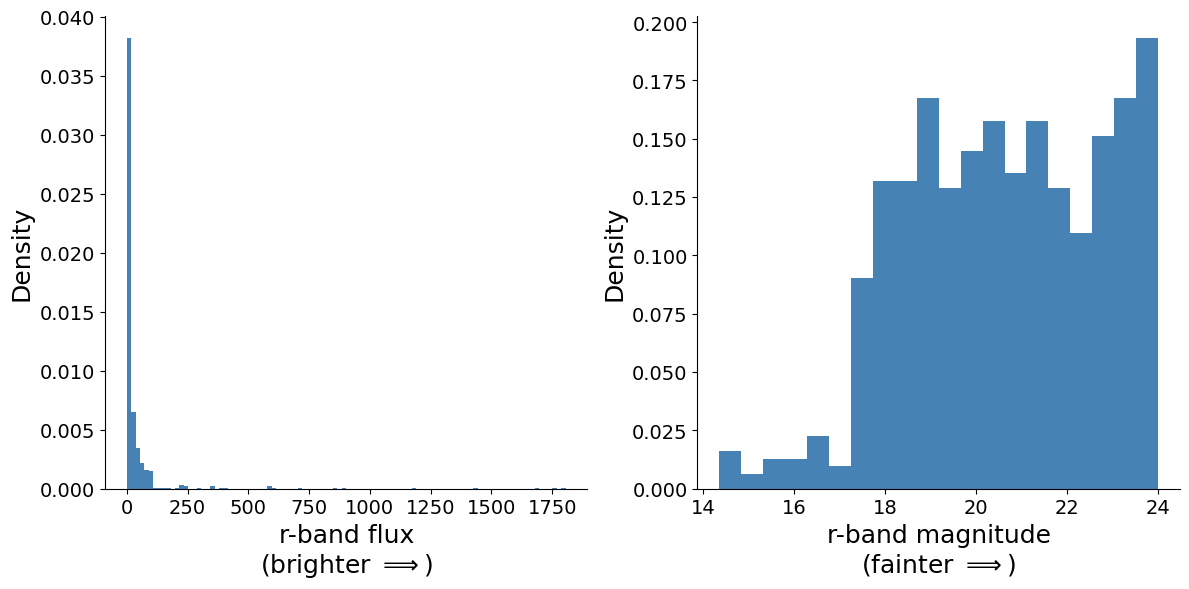

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

_ = ax[0].hist(fluxes_magcut_oob, bins = 100, density = True, color = "steelblue")
_ = ax[0].set_xlabel("r-band flux\n(brighter $\Longrightarrow$)", fontsize = 18)
_ = ax[0].set_ylabel("Density", fontsize = 18)

_ = ax[1].hist(mags_magcut_oob, bins = 20, density = True, color = "steelblue")
_ = ax[1].set_xlabel("r-band magnitude\n(fainter $\Longrightarrow$)", fontsize = 18)
_ = ax[1].set_ylabel("Density", fontsize = 18)

for a in ax.flat:
    _ = a.tick_params(axis = "both", which = "major", labelsize = 14)
    _ = a.spines[['top', 'right']].set_visible(False)

_ = fig.tight_layout()

fig.savefig('results/figures/m71_flux_prior.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [21]:
alpha, trunc, loc, scale = truncpareto.fit(fluxes_magcut_oob, floc = 0)
print(f"alpha = {alpha}, trunc = {trunc}, loc = {loc}, scale = {scale}")

alpha = 0.21411753249015655, trunc = 7171.335384801955, loc = 0, scale = 0.25165176391601557


In [22]:
f = np.logspace(np.log10(loc + scale + 1e-4), np.log10(loc + trunc*scale - 1e-4), 200)
pf = truncpareto.pdf(f, alpha, trunc, loc, scale)

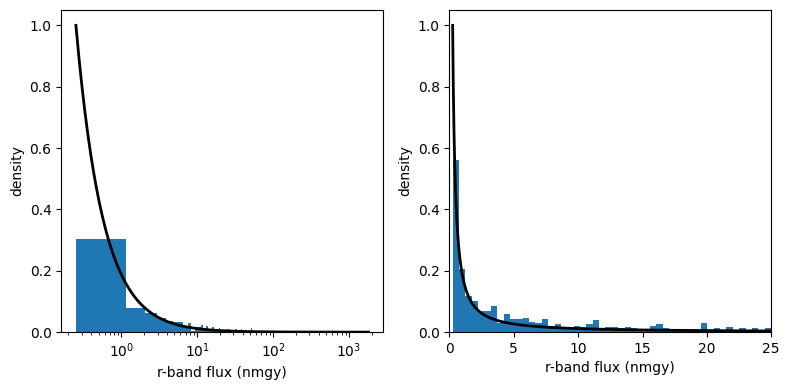

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

_ = ax[0].plot(f, pf, color = 'black', linewidth = 2)
_ = ax[0].hist(fluxes_magcut_oob[fluxes_magcut_oob < trunc], density = True, bins = 2000)
_ = ax[0].set_xscale('log')
_ = ax[0].set_xlabel('r-band flux (nmgy)')
_ = ax[0].set_ylabel('density')

_ = ax[1].plot(f, pf, color = 'black', linewidth = 2)
_ = ax[1].hist(fluxes_magcut_oob[fluxes_magcut_oob < 25], density = True, bins = 50)
_ = ax[1].set_xlim(0, 25)
_ = ax[1].set_xlabel('r-band flux (nmgy)')
_ = ax[1].set_ylabel('density')

_ = fig.tight_layout()

---

### **Flux prior (alternative parametrization)**

We can also define the truncated (i.e., bounded) Pareto distribution above using the parametrization from [this page](https://en.wikipedia.org/wiki/Pareto_distribution#Bounded_Pareto_distribution).

In [24]:
alpha = alpha
L = loc + scale
H = loc + trunc*scale
print(f"alpha = {alpha}, L = {L}, H = {H}")

alpha = 0.21411753249015655, L = 0.25165176391601557, H = 1804.6791992187502


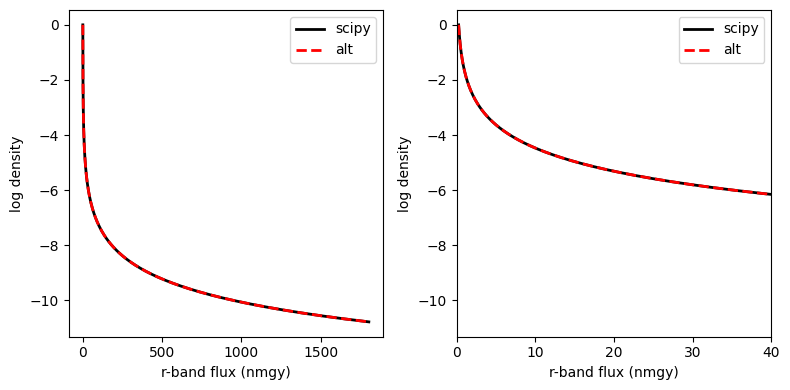

In [25]:
pf_alt = (alpha * (L**alpha) * (f**(-alpha-1))) / (1 - (L/H)**alpha)

fig, ax = plt.subplots(1, 2, figsize = (8, 4))

_ = ax[0].plot(f, np.log(pf), color = 'black', linewidth = 2, label = 'scipy')
_ = ax[0].plot(f, np.log(pf_alt), color = 'red', linewidth = 2, linestyle = 'dashed', label = 'alt')
_ = ax[0].set_xlabel('r-band flux (nmgy)')
_ = ax[0].set_ylabel('log density')
_ = ax[0].legend()

_ = ax[1].plot(f, np.log(pf), color = 'black', linewidth = 2, label = 'scipy')
_ = ax[1].plot(f, np.log(pf_alt), color = 'red', linewidth = 2, linestyle = 'dashed', label = 'alt')
_ = ax[1].set_xlim(0, 40)
_ = ax[1].set_xlabel('r-band flux (nmgy)')
_ = ax[1].set_ylabel('log density')
_ = ax[1].legend()

_ = fig.tight_layout()

We can sample from this distribution using inverse transform sampling:

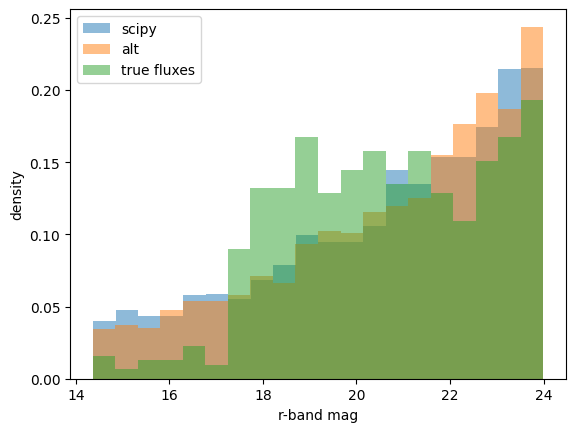

In [26]:
num_samples = 5*fluxes_magcut_oob.shape[0]

unif = torch.rand(num_samples)
samples = ( (H**alpha - unif * (H**alpha) + unif*(L**alpha)) / ((L**alpha) * (H**alpha)) )**(-1/alpha)

_ = plt.hist(convert_nmgy_to_mag(torch.tensor(truncpareto(alpha, trunc, loc, scale).rvs(num_samples))),
             bins = 20, alpha = 0.5, density = True, label = 'scipy')
_ = plt.hist(convert_nmgy_to_mag(samples), bins = 20, alpha = 0.5, density = True, label = 'alt')
_ = plt.hist(convert_nmgy_to_mag(fluxes_magcut_oob), bins = 20, alpha = 0.5, density = True, label = 'true fluxes')
_ = plt.xlabel('r-band mag')
_ = plt.ylabel('density')
_ = plt.legend()

I implemented this alternative parametrization in the `TruncatedPareto` class in `smc/distributions.py`:

In [27]:
f = np.logspace(np.log10(loc + scale + 1e-4), np.log10(loc + trunc*scale - 1e-4), 200)
pf = truncpareto.pdf(f, alpha, trunc, loc, scale)
pf_alt = (alpha * (L**alpha) * (f**(-alpha-1))) / (1 - (L/H)**alpha)

In [28]:
from smcdet.distributions import TruncatedPareto

my_truncpareto = TruncatedPareto(alpha = alpha, lower = L, upper = H)

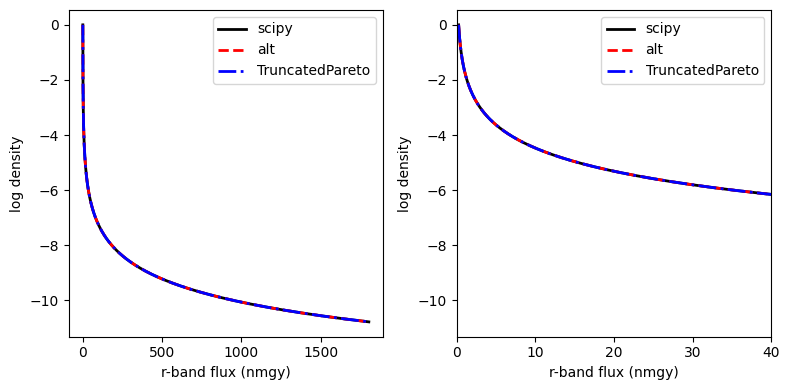

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

_ = ax[0].plot(f, np.log(pf), color = 'black', linewidth = 2, label = 'scipy')
_ = ax[0].plot(f, np.log(pf_alt), color = 'red', linewidth = 2, linestyle = 'dashed', label = 'alt')
_ = ax[0].plot(f, my_truncpareto.log_prob(torch.tensor(f)),
               color = 'blue', linewidth = 2, linestyle = 'dashdot', label = 'TruncatedPareto')
_ = ax[0].set_xlabel('r-band flux (nmgy)')
_ = ax[0].set_ylabel('log density')
_ = ax[0].legend()

_ = ax[1].plot(f, np.log(pf), color = 'black', linewidth = 2, label = 'scipy')
_ = ax[1].plot(f, np.log(pf_alt), color = 'red', linewidth = 2, linestyle = 'dashed', label = 'alt')
_ = ax[1].plot(f, my_truncpareto.log_prob(torch.tensor(f)),
               color = 'blue', linewidth = 2, linestyle = 'dashdot', label = 'TruncatedPareto')
_ = ax[1].set_xlim(0,40)
_ = ax[1].set_xlabel('r-band flux (nmgy)')
_ = ax[1].set_ylabel('log density')

_ = ax[1].legend()

_ = fig.tight_layout()

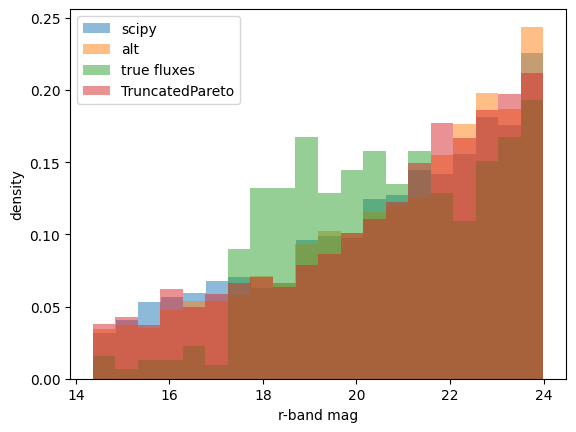

In [30]:
_ = plt.hist(convert_nmgy_to_mag(torch.tensor(truncpareto(alpha, trunc, loc, scale).rvs(num_samples))),
             bins = 20, alpha = 0.5, density = True, label = 'scipy')
_ = plt.hist(convert_nmgy_to_mag(samples), bins = 20, alpha = 0.5, density = True, label = 'alt')
_ = plt.hist(convert_nmgy_to_mag(fluxes_magcut_oob), bins = 20, alpha = 0.5, density = True, label = 'true fluxes')
_ = plt.hist(convert_nmgy_to_mag(my_truncpareto.sample(num_samples)),
             bins = 20, alpha = 0.5, density = True, label = 'TruncatedPareto')
_ = plt.xlabel('r-band mag')
_ = plt.ylabel('density')
_ = plt.legend()

---

### **Count prior**

We fit a flux prior using the tiles that were not stored above (i.e., the opposite-color squares on the checkerboard).

In [31]:
counts_magcut_oob = tile_pruned_counts_magcut[~checkerboard_mask & ~saturation_mask_with_neighbors]

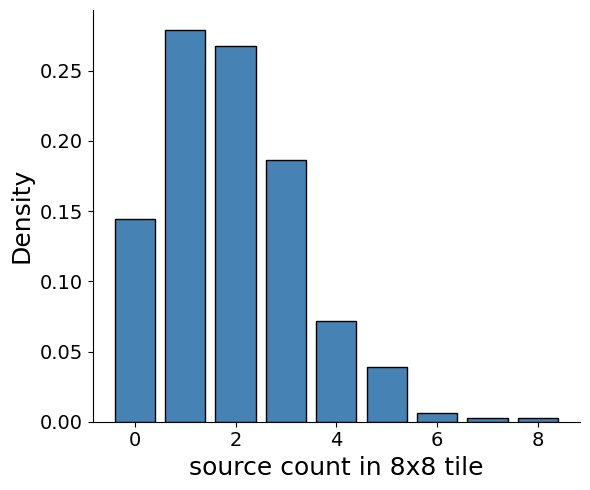

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))

c, d = counts_magcut_oob.unique(return_counts = True)

_ = ax.bar(c, d/d.sum(), color = "steelblue", edgecolor = "black", align = "center")
_ = ax.set_xlabel("source count in 8x8 tile", fontsize = 18)
_ = ax.set_ylabel("Density", fontsize = 18)
_ = ax.tick_params(axis = "both", which = "major", labelsize = 14)
_ = ax.spines[['top', 'right']].set_visible(False)

_ = fig.tight_layout()

fig.savefig('results/figures/m71_count_prior.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [33]:
# MLE of Poisson rate parameter (i.e., average number of stars per pixel)
counts_rate = (counts_magcut_oob.sum() / ((~checkerboard_mask & ~saturation_mask_with_neighbors).sum())) / (tile_dim ** 2)
print(f"rate = {counts_rate.item()}")

rate = 0.030264640226960182


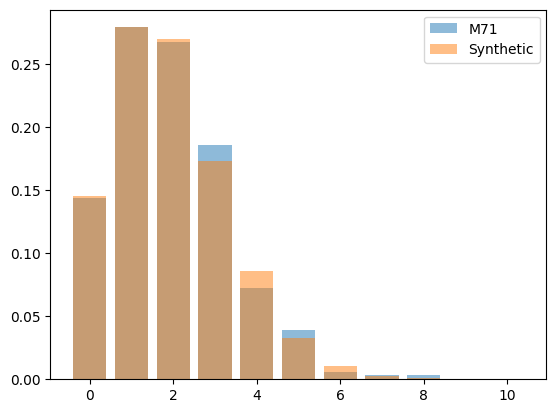

In [34]:
c1, d1 = counts_magcut_oob.unique(return_counts = True)
_ = plt.bar(c1, d1/d1.sum(), alpha = 0.5, label = 'M71')

torch.manual_seed(0)
random_sample = Poisson(counts_rate * (tile_dim ** 2)).sample([100000])
c2, d2 = random_sample.unique(return_counts = True)
_ = plt.bar(c2, d2/d2.sum(), alpha = 0.5, label = 'Synthetic')

_ = plt.legend()

---

### **Image model**

##### Background

We plot the r-band background of the entire SDSS field (in nelec, but we could also plot it in ADU):

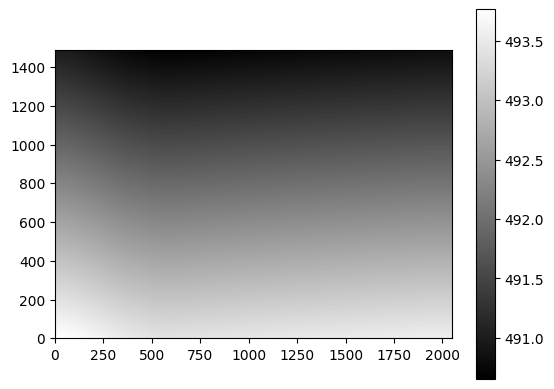

In [35]:
_ = plt.imshow(wholefield_background_nelec, cmap = 'gray', origin = 'lower')
_ = plt.colorbar()

For our target region, we'll approximate it using the mean:

In [36]:
background_nelec = torch.tensor(wholefield_background_nelec[900:1220, 1728:1888])
background_nelec_mean = background_nelec.mean().item()
background_adu = torch.tensor(wholefield_background_adu[900:1220, 1728:1888])
background_adu_mean = background_adu.mean().item()
print(f'background mean in nelec = {background_nelec_mean}')
print(f'background mean in adu = {background_adu_mean}')

background mean in nelec = 491.5815734863281
background mean in adu = 104.14863586425781


### Unit conversions

The gain in the r-band is a scalar:

In [37]:
gain

4.72

The conversion between nanomaggies and number of electrons varies slightly across the 160 columns of our target region:

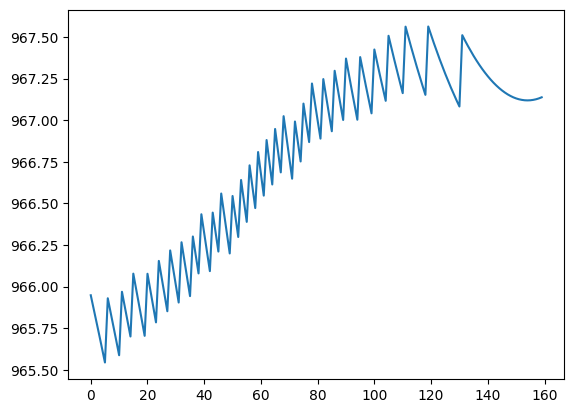

In [38]:
nelec_per_nmgy = wholefield_nelec_per_nmgy[1728:1888]
_ = plt.plot(nelec_per_nmgy)

We'll approximate it using the mean:

In [39]:
nelec_per_nmgy_mean = nelec_per_nmgy.mean()
nelec_per_nmgy_mean

966.76624

We'll do the same for the conversion between ADU and nanomaggies:

In [40]:
adu_per_nmgy = wholefield_adu_per_nmgy[1728:1888]
adu_per_nmgy_mean = adu_per_nmgy.mean()
adu_per_nmgy_mean

204.82333

We now check our understanding of all of these conversions. First, we verify that image_nelec = image_nmgy * nelec_per_nmgy + background_nelec:

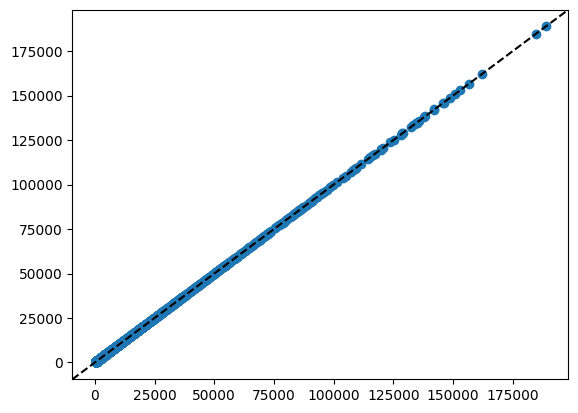

In [41]:
assert ((image_nelec - (image_nmgy * nelec_per_nmgy + background_nelec)).abs() < 1e-2).all()

_ = plt.scatter((image_nmgy * nelec_per_nmgy + background_nelec).flatten(),
                image_nelec.flatten())
_ = plt.axline((0, 0), slope = 1, color = 'black', linestyle = 'dashed')

And second, we verify that image_adu = image_nmgy * adu_per_nmgy + background_adu:

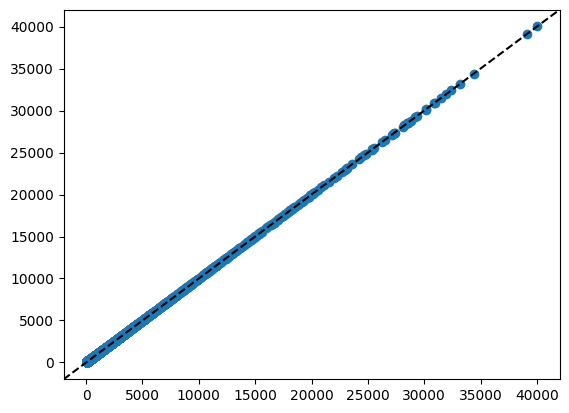

In [42]:
assert ((image_adu - (image_nmgy * adu_per_nmgy + background_adu)).abs() < 1e-2).all()

_ = plt.scatter((image_nmgy * adu_per_nmgy + background_adu).flatten(),
                image_adu.flatten())
_ = plt.axline((0, 0), slope = 1, color = 'black', linestyle = 'dashed')

### Point-spread function

We plot the rasterized r-band SDSS point-spread function:

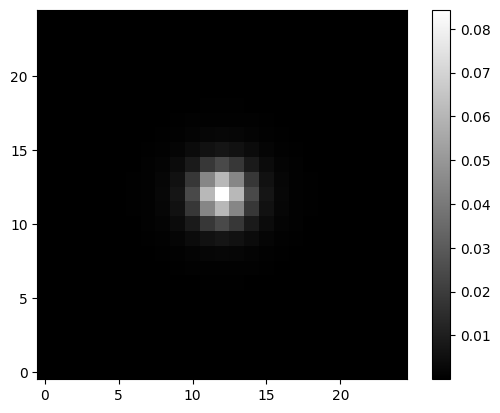

In [43]:
sdss_psf = sdss.psf.psf_galsim[sdss.image_id(0)][2].original.image.array

_ = plt.imshow(sdss_psf, cmap = 'gray', origin = 'lower')
_ = plt.colorbar()

If we fit a Gaussian profile to this PSF, we get the following (isotropic) standard deviation:

In [44]:
h, _ = np.indices(sdss_psf.shape)
sdss_psf_stdev = np.sqrt((((h - 12.0)**2) * sdss_psf).sum())
sdss_psf_stdev

1.9273269405185427

The above PSF is rasterized, so it may not be accurate for sources that don't lie exactly in the middle of a pixel. SDSS actually uses a more complicated PSF that combines two Gaussians and a power-law. The parameters of this model in the r-band are as follows:

In [45]:
sdss.psf.psf_params[sdss.image_id(0)][2]

tensor([1.3600e+00, 4.8475e+00, 8.3333e+00, 3.0000e+00, 1.4400e-01, 6.8779e-03])

We investigate the differences between this model-based PSF, the rasterized SDSS PSF, and a Gaussian PSF in `psf_comparison.ipynb`, and we estimate these six parameters ourselves below.

---

### **Optimize image model parameters**

We'll fit some of the image model parameters on a smaller region of M71 separate from of our target region (with saturated tiles masked out).

We'll assume the SDSS-reported background and PSF parameters background are correct. We'll estimate the read noise in additive and multiplicative components. Also since the Hubble v-band uses a different filter than the SDSS r-band, the fluxes in nmgy are slightly different between the two datasets. As a result, the ADU per nmgy conversion that we examined above is only accurate for SDSS fluxes. But we don't have SDSS fluxes, we only have Hubble fluxes. Therefore, we'll also estimate the conversion factor between Hubble nmgy and SDSS ADU, which should be appoximately `adu_per_nmgy` scaled by a multiplicative factor (which ends up being between 1.1 and 1.2).

In [46]:
torch.set_default_device(device)

In [47]:
hlower = 1225
hupper = 1345
wlower = 1728
wupper = 1888

In [48]:
psf_image = torch.from_numpy(wholefield_adu[hlower:hupper, wlower:wupper].astype(np.float32)).to(device)
psf_locs_mask = (locs_all[:,0] > hlower) & (locs_all[:,0] < hupper)
psf_locs_mask &= (locs_all[:,1] > wlower) & (locs_all[:,1] < wupper)

psf_locs = locs_all[psf_locs_mask].to(dtype = torch.float32, device = device)
psf_locs -= torch.tensor([hlower, wlower])
psf_fluxes = fluxes_all[psf_locs_mask].to(dtype = torch.float32, device = device)

In [49]:
psf_saturated_locs = psf_locs[(convert_nmgy_to_mag(psf_fluxes) < 14)]

psf_saturation_mask = torch.tensor([[((h - psf_saturated_locs[:,0]).abs() < 1.5*tile_dim) & ((w - psf_saturated_locs[:,1]).abs() < 1.5*tile_dim) for w in range(psf_image.shape[1])] for h in range(psf_image.shape[0])])

In [50]:
log_psf_params = sdss.psf.psf_params[sdss.image_id(0)][2].clone().log().to(device)
log_noise_multiplicative = torch.ones(1).log()
log_noise_additive = torch.tensor(1e-10).log()
log_background = torch.tensor(background_adu_mean).log()
log_adu_per_nmgy = torch.tensor(adu_per_nmgy_mean).log()

We set `psf_radius` to a large value so that the PSF of stars in the padded region covers a sufficient area within the image boundary:

In [51]:
image_model = M71ImageModel(image_height = psf_image.shape[0],
                            image_width = psf_image.shape[1],
                            background = log_background.exp(),
                            adu_per_nmgy = log_adu_per_nmgy.exp(),
                            psf_params = log_psf_params.exp(),
                            psf_radius = 16,
                            noise_additive = log_noise_additive.exp(),
                            noise_multiplicative = log_noise_multiplicative.exp())

In [52]:
log_psf_params = torch.nn.Parameter(log_psf_params)
log_noise_additive = torch.nn.Parameter(log_noise_additive)
log_noise_multiplicative = torch.nn.Parameter(log_noise_multiplicative)
log_adu_per_nmgy = torch.nn.Parameter(log_adu_per_nmgy)

optimizer = torch.optim.LBFGS([log_adu_per_nmgy, log_psf_params, log_noise_multiplicative, log_noise_additive],
                              lr = 1, max_iter = 500, line_search_fn = "strong_wolfe")

def compute_loss():
    optimizer.zero_grad()

    log_sigma1, log_sigma2, log_sigmap, log_beta, log_b, log_p0 = log_psf_params
    sigma1 = log_sigma1.exp()
    sigma2 = log_sigma2.exp()
    sigmap = log_sigmap.exp()
    beta = log_beta.exp()
    b = log_b.exp()
    p0 = log_p0.exp()

    # compute normalizing constant
    psf_marginal_h = torch.arange(0, 32 * image_model.psf_radius)
    psf_marginal_w = torch.arange(0, 32 * image_model.psf_radius)
    grid_h, grid_w = torch.meshgrid(psf_marginal_h, psf_marginal_w, indexing="ij")
    big_psf_grid = torch.stack([grid_h, grid_w], dim=-1)
    one_loc_in_center = torch.tensor(
        [psf_marginal_h.shape[0] / 2.0, psf_marginal_w.shape[0] / 2.0]
    )
    psf_grid_adjusted = (
        big_psf_grid - rearrange(one_loc_in_center, "t -> 1 1 t") + 0.5
    )
    r = (psf_grid_adjusted**2).sum(-1).sqrt()
    term1 = torch.exp(-(r**2) / (2 * sigma1))
    term2 = b * torch.exp(-(r**2) / (2 * sigma2))
    term3 = p0 * (1 + r**2 / (beta * sigmap)) ** (-beta / 2)
    unnormalized_psf = (term1 + term2 + term3) / (1 + b + p0)
    psf_normalizing_constant = unnormalized_psf.sum()

    numH, numW, n, d, _ = rearrange(psf_locs, "d t -> 1 1 1 d t").shape

    star_centers = rearrange(rearrange(psf_locs, "d t -> 1 1 1 d t"), "numH numW n d t -> numH numW n d 1 1 t")

    pixel_coords = torch.floor(star_centers) + rearrange(
        image_model.psf_patch, "dimH dimW t -> 1 1 1 1 dimH dimW t"
    )

    h_in_bounds = (pixel_coords[..., 0] >= 0) & (
        pixel_coords[..., 0] < image_model.image_height
    )
    w_in_bounds = (pixel_coords[..., 1] >= 0) & (
        pixel_coords[..., 1] < image_model.image_width
    )
    coords_in_bounds = h_in_bounds & w_in_bounds

    r = torch.norm((pixel_coords + 0.5) - star_centers, dim=-1)

    if coords_in_bounds.any():
        h_tile, w_tile, n_idx, d_idx, h_patch, w_patch = torch.where(
            coords_in_bounds
        )
        valid_r = r[coords_in_bounds]
        term1 = torch.exp(-(valid_r**2) / (2 * sigma1))
        term2 = b * torch.exp(-(valid_r**2) / (2 * sigma2))
        term3 = p0 * (1 + valid_r**2 / (beta * sigmap)) ** (-beta / 2)
        valid_psf_vals_unnormalized = (term1 + term2 + term3) / (1 + b + p0)
        valid_psf_vals = valid_psf_vals_unnormalized / psf_normalizing_constant

        pixel_coords_int = pixel_coords.long()
        target_h = pixel_coords_int[
            h_tile, w_tile, n_idx, d_idx, h_patch, w_patch, 0
        ]
        target_w = pixel_coords_int[
            h_tile, w_tile, n_idx, d_idx, h_patch, w_patch, 1
        ]

        linear_indices = (
            h_tile * numW * image_model.image_height * image_model.image_width * n * d
            + w_tile * image_model.image_height * image_model.image_width * n * d
            + target_h * image_model.image_width * n * d
            + target_w * n * d
            + n_idx * d
            + d_idx
        )

        psf_flat = torch.zeros(
            numH * numW * image_model.image_height * image_model.image_width * n * d
        )
        psf_flat.scatter_add_(0, linear_indices, valid_psf_vals)

    psf = psf_flat.view(numH, numW, image_model.image_height, image_model.image_width, n, d)
    
    rate = (
        psf
        * rearrange(
            log_adu_per_nmgy.exp() * psf_fluxes,
            "d -> 1 1 d"
        )
    ).sum(-1).squeeze() + log_background.exp()

    # compute loglikelihood (mask saturated pixels and outer frame of width 10 pixels)
    dist = Normal(rate, (log_noise_additive.exp() + log_noise_multiplicative.exp() * rate).sqrt())
    log_likelihood = dist.log_prob(psf_image)[10:-10,10:-10][~psf_saturation_mask[10:-10,10:-10]].sum()
    loss = -log_likelihood
    loss.backward()
    return loss

for i in range(10):
    loss = optimizer.step(compute_loss)
    print(f"iteration {i}: loss = {loss.item():.4f}")

iteration 0: loss = 98954.7266
iteration 1: loss = 58394.4375
iteration 2: loss = 58394.4375
iteration 3: loss = 58394.4375
iteration 4: loss = 58394.4297
iteration 5: loss = 58394.4297
iteration 6: loss = 58394.4297
iteration 7: loss = 58394.4297
iteration 8: loss = 58394.4297
iteration 9: loss = 58394.4297


We can verify that the rate evaluated at the MLEs of the parameters looks like a reasonable approximation of the actual image:

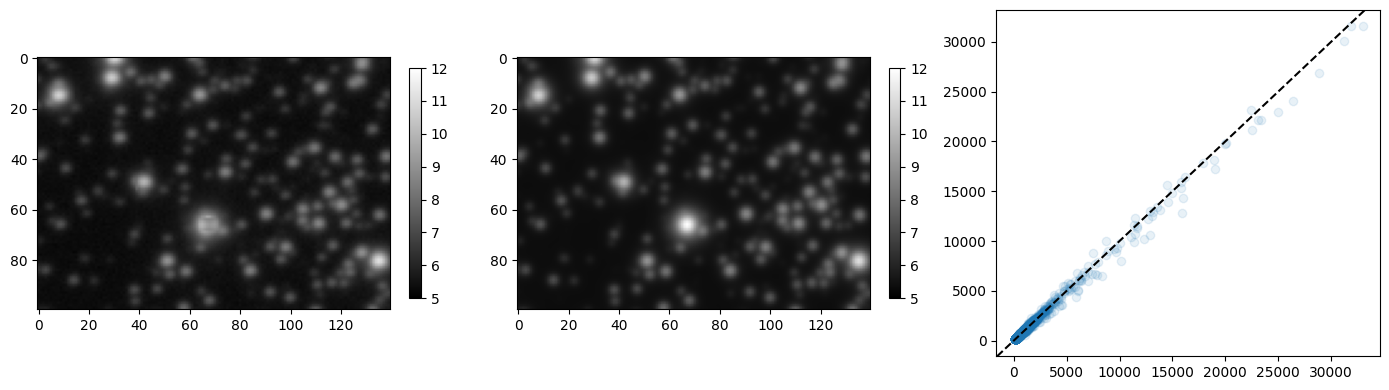

In [53]:
log_sigma1, log_sigma2, log_sigmap, log_beta, log_b, log_p0 = log_psf_params
sigma1 = log_sigma1.exp()
sigma2 = log_sigma2.exp()
sigmap = log_sigmap.exp()
beta = log_beta.exp()
b = log_b.exp()
p0 = log_p0.exp()

# compute normalizing constant
psf_marginal_h = torch.arange(0, 32 * image_model.psf_radius)
psf_marginal_w = torch.arange(0, 32 * image_model.psf_radius)
grid_h, grid_w = torch.meshgrid(psf_marginal_h, psf_marginal_w, indexing="ij")
big_psf_grid = torch.stack([grid_h, grid_w], dim=-1)
one_loc_in_center = torch.tensor(
    [psf_marginal_h.shape[0] / 2.0, psf_marginal_w.shape[0] / 2.0]
)
psf_grid_adjusted = (
    big_psf_grid - rearrange(one_loc_in_center, "t -> 1 1 t") + 0.5
)
r = (psf_grid_adjusted**2).sum(-1).sqrt()
term1 = torch.exp(-(r**2) / (2 * sigma1))
term2 = b * torch.exp(-(r**2) / (2 * sigma2))
term3 = p0 * (1 + r**2 / (beta * sigmap)) ** (-beta / 2)
unnormalized_psf = (term1 + term2 + term3) / (1 + b + p0)
psf_normalizing_constant = unnormalized_psf.sum()

numH, numW, n, d, _ = rearrange(psf_locs, "d t -> 1 1 1 d t").shape

star_centers = rearrange(rearrange(psf_locs, "d t -> 1 1 1 d t"), "numH numW n d t -> numH numW n d 1 1 t")

pixel_coords = torch.floor(star_centers) + rearrange(
    image_model.psf_patch, "dimH dimW t -> 1 1 1 1 dimH dimW t"
)

h_in_bounds = (pixel_coords[..., 0] >= 0) & (
    pixel_coords[..., 0] < image_model.image_height
)
w_in_bounds = (pixel_coords[..., 1] >= 0) & (
    pixel_coords[..., 1] < image_model.image_width
)
coords_in_bounds = h_in_bounds & w_in_bounds

r = torch.norm((pixel_coords + 0.5) - star_centers, dim=-1)

if coords_in_bounds.any():
    h_tile, w_tile, n_idx, d_idx, h_patch, w_patch = torch.where(
        coords_in_bounds
    )
    valid_r = r[coords_in_bounds]
    term1 = torch.exp(-(valid_r**2) / (2 * sigma1))
    term2 = b * torch.exp(-(valid_r**2) / (2 * sigma2))
    term3 = p0 * (1 + valid_r**2 / (beta * sigmap)) ** (-beta / 2)
    valid_psf_vals_unnormalized = (term1 + term2 + term3) / (1 + b + p0)
    valid_psf_vals = valid_psf_vals_unnormalized / psf_normalizing_constant

    pixel_coords_int = pixel_coords.long()
    target_h = pixel_coords_int[
        h_tile, w_tile, n_idx, d_idx, h_patch, w_patch, 0
    ]
    target_w = pixel_coords_int[
        h_tile, w_tile, n_idx, d_idx, h_patch, w_patch, 1
    ]

    linear_indices = (
        h_tile * numW * image_model.image_height * image_model.image_width * n * d
        + w_tile * image_model.image_height * image_model.image_width * n * d
        + target_h * image_model.image_width * n * d
        + target_w * n * d
        + n_idx * d
        + d_idx
    )

    psf_flat = torch.zeros(
        numH * numW * image_model.image_height * image_model.image_width * n * d
    )
    psf_flat.scatter_add_(0, linear_indices, valid_psf_vals)

psf = psf_flat.view(numH, numW, image_model.image_height, image_model.image_width, n, d)


rate = (
    psf
    * rearrange(
        log_adu_per_nmgy.exp() * psf_fluxes,
        "d -> 1 1 d"
    )
).sum(-1).squeeze() + log_background.exp()

fig, ax = plt.subplots(1, 3, figsize = (14,4))
tmp0 = ax[0].imshow(psf_image[10:-10,10:-10].arcsinh().detach().cpu(), cmap = 'gray', vmin = 5, vmax = 12)
_ = plt.colorbar(tmp0, fraction = 0.03)

tmp1 = ax[1].imshow(rate[10:-10,10:-10].arcsinh().detach().cpu(), cmap = 'gray', vmin = 5, vmax = 12)
_ = plt.colorbar(tmp1, fraction = 0.03)

_ = ax[2].scatter(psf_image[10:-10,10:-10][~psf_saturation_mask[10:-10,10:-10]].detach().cpu(),
                  rate[10:-10,10:-10][~psf_saturation_mask[10:-10,10:-10]].detach().cpu(), alpha = 0.1)
_ = ax[2].axline((0,0), slope = 1, color = 'black', linestyle = 'dashed')

fig.tight_layout()

In [54]:
optimized_psf_params = log_psf_params.exp().detach().cpu()
print(f"SDSS default PSF params: {sdss.psf.psf_params[sdss.image_id(0)][2].tolist()}")
print(f"optimized PSF params: {optimized_psf_params.tolist()}\n")

optimized_adu_per_nmgy = log_adu_per_nmgy.exp().item()
print(f"mean of SDSS-reported ADU per (SDSS) nmgy: {adu_per_nmgy_mean}")
print(f"optimized ADU per (Hubble) nmgy: {optimized_adu_per_nmgy}\n")

optimized_noise_additive = log_noise_additive.exp().item()
print(f"optimized additive noise: {optimized_noise_additive}\n")

optimized_noise_multiplicative = log_noise_multiplicative.exp().item()
print(f"optimized multiplicative noise: {optimized_noise_multiplicative}\n")

SDSS default PSF params: [1.359987497329712, 4.847548961639404, 8.333333969116211, 3.0, 0.14399570226669312, 0.006877879612147808]
optimized PSF params: [1.107237458229065, 2.0800251960754395, 2.3254318237304688, 5.240590572357178, 0.7346734404563904, 0.5114791393280029]

mean of SDSS-reported ADU per (SDSS) nmgy: 204.82333374023438
optimized ADU per (Hubble) nmgy: 241.02658081054688

optimized additive noise: 1.0000007072408224e-10

optimized multiplicative noise: 1.936462640762329



---

### **Save fitted prior and image model parameters**

For the flux prior, we decrease the lower bound of the truncated Pareto distribution to enable detection of stars fainter than the minimum flux observed in the off-color tiles.

In [55]:
d = {
    "flux_alpha": alpha,
    "flux_lower": 0.25 * L,
    "flux_upper": H,
    "flux_detection_threshold": L,
    "counts_rate": counts_rate.item(),
    "background": log_background.exp().item(),
    "adu_per_nmgy": optimized_adu_per_nmgy,
    "psf_params": optimized_psf_params,
    "psf_radius": 8,
    "noise_additive": optimized_noise_additive,
    "noise_multiplicative": optimized_noise_multiplicative
}

d

{'flux_alpha': 0.21411753249015655,
 'flux_lower': 0.06291294097900389,
 'flux_upper': 1804.6791992187502,
 'flux_detection_threshold': 0.25165176391601557,
 'counts_rate': 0.030264640226960182,
 'background': 104.1486587524414,
 'adu_per_nmgy': 241.02658081054688,
 'psf_params': tensor([1.1072, 2.0800, 2.3254, 5.2406, 0.7347, 0.5115]),
 'psf_radius': 8,
 'noise_additive': 1.0000007072408224e-10,
 'noise_multiplicative': 1.936462640762329}

In [56]:
with open('data/params.pkl', 'wb') as file:
    pickle.dump(d, file)

---

### **An example tile with substantial blending and a star near the detection limit**

In [57]:
torch.set_default_device('cpu')

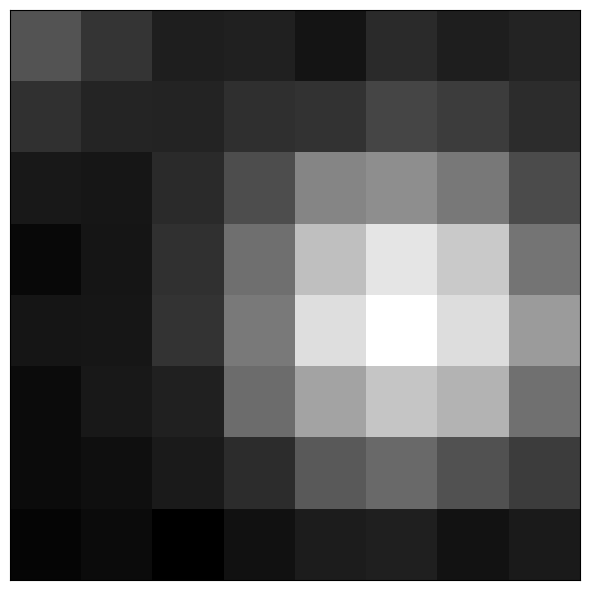

In [58]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

idx = 66
example_tile = tiles_adu[checkerboard_mask & ~saturation_mask_with_neighbors][idx]
example_counts = tile_pruned_counts_magcut[checkerboard_mask & ~saturation_mask_with_neighbors][idx].int()
example_locs = tile_pruned_locs_magcut[checkerboard_mask & ~saturation_mask_with_neighbors][idx]
example_fluxes = tile_pruned_fluxes_magcut[checkerboard_mask & ~saturation_mask_with_neighbors][idx]

_ = ax.imshow(example_tile.arcsinh().cpu(), cmap = 'gray')
_ = ax.set_xticks([])
_ = ax.set_yticks([])

_ = fig.tight_layout()

fig.savefig('results/figures/example_tile.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

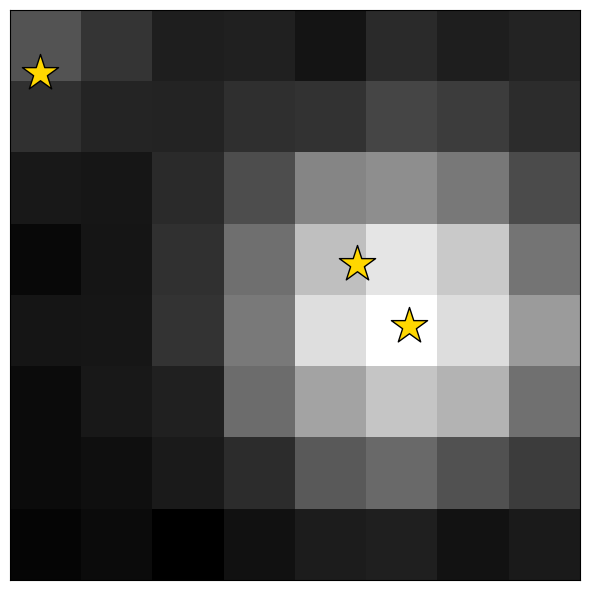

In [59]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

_ = ax.imshow(example_tile.arcsinh().cpu(), cmap = 'gray')
_ = ax.scatter(example_locs[:example_counts,1] - 0.5,
               example_locs[:example_counts,0] - 0.5,
               color = 'gold', s = 750, marker = '*', edgecolors = 'black')
_ = ax.set_xticks([])
_ = ax.set_yticks([])

_ = fig.tight_layout()

fig.savefig('results/figures/example_tile_with_detections.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

We plot some example catalogs:

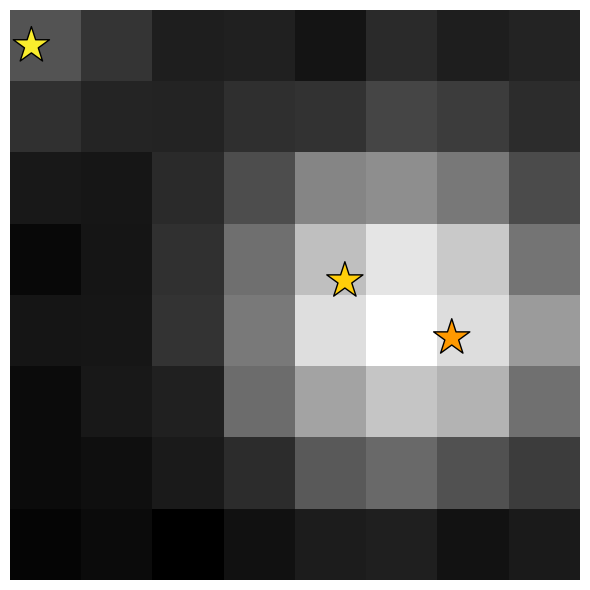

In [60]:
# three stars

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

sample_locs = torch.tensor([[4.6,6.2],[3.8,4.7],[0.5,0.3]]).cpu()
sample_fluxes = torch.tensor([20.0,10.0,5.0]).cpu()

_ = ax.imshow(example_tile.arcsinh().cpu(), cmap = 'gray')
flux = ax.scatter(sample_locs[:,1] - 0.5, sample_locs[:,0] - 0.5, c = sample_fluxes, cmap = 'Wistia', s = 750, marker = '*', edgecolors = 'black', vmin = 0, vmax = 25)
_ = ax.set_xticks([])
_ = ax.set_yticks([])
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

_ = fig.tight_layout()

fig.savefig('results/figures/example_tile_sample1.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

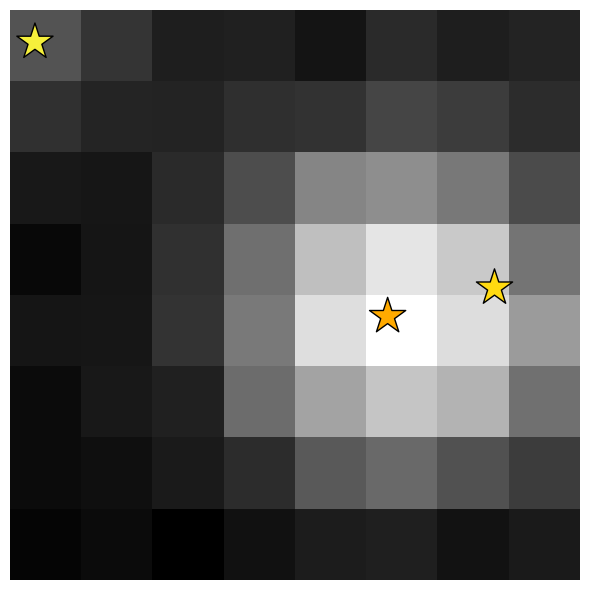

In [61]:
# three stars mutated

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

sample_locs = torch.tensor([[3.9,6.8],[4.3,5.3],[0.45,0.35]]).cpu()
sample_fluxes = torch.tensor([10.0,20.0,5.0]).cpu()

_ = ax.imshow(example_tile.arcsinh().cpu(), cmap = 'gray')
flux = ax.scatter(sample_locs[:,1] - 0.5, sample_locs[:,0] - 0.5, c = sample_fluxes, cmap = 'Wistia', s = 750, marker = '*', edgecolors = 'black', vmin = 0, vmax = 30)
_ = ax.set_xticks([])
_ = ax.set_yticks([])
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

_ = fig.tight_layout()

fig.savefig('results/figures/example_tile_sample2.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

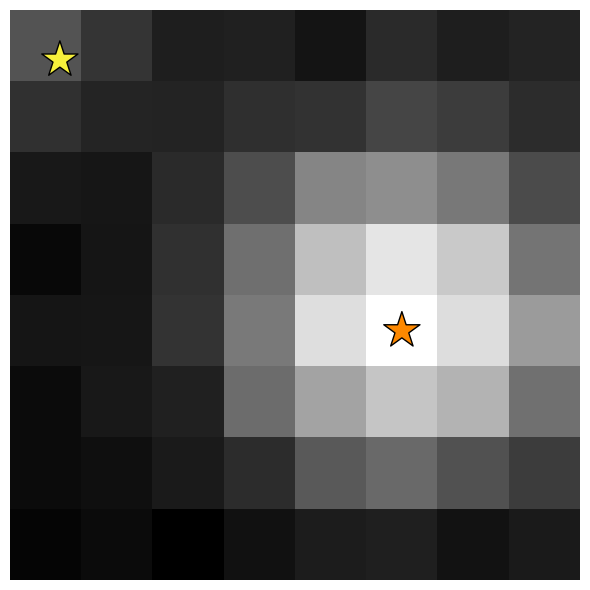

In [62]:
# two stars

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

sample_locs = torch.tensor([[4.5,5.5],[0.7,0.7]]).cpu()
sample_fluxes = torch.tensor([28.0,5.0]).cpu()

_ = ax.imshow(example_tile.arcsinh().cpu(), cmap = 'gray')
flux = ax.scatter(sample_locs[:,1] - 0.5, sample_locs[:,0] - 0.5, c = sample_fluxes, cmap = 'Wistia', s = 750, marker = '*', edgecolors = 'black', vmin = 0, vmax = 30)
_ = ax.set_xticks([])
_ = ax.set_yticks([])
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

_ = fig.tight_layout()

fig.savefig('results/figures/example_tile_sample3.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

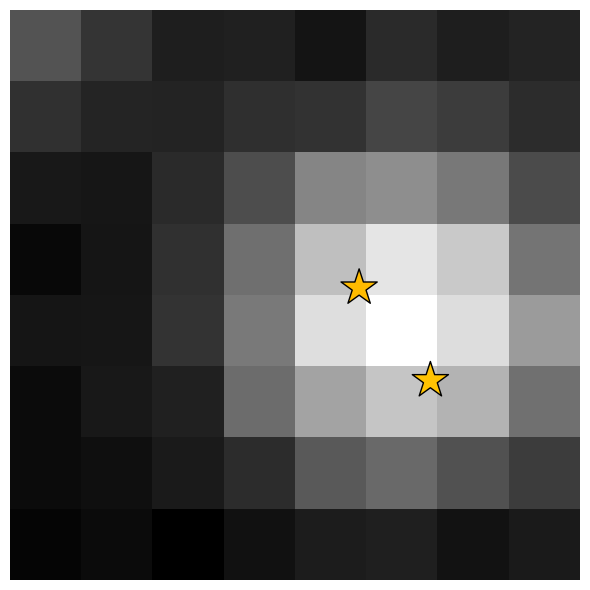

In [63]:
# two stars mutated

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

sample_locs = torch.tensor([[3.9,4.9],[5.2,5.9]]).cpu()
sample_fluxes = torch.tensor([15.5,14.0]).cpu()

_ = ax.imshow(example_tile.arcsinh().cpu(), cmap = 'gray')
flux = ax.scatter(sample_locs[:,1] - 0.5, sample_locs[:,0] - 0.5, c = sample_fluxes, cmap = 'Wistia', s = 750, marker = '*', edgecolors = 'black', vmin = 0, vmax = 30)
_ = ax.set_xticks([])
_ = ax.set_yticks([])
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

_ = fig.tight_layout()

fig.savefig('results/figures/example_tile_sample4.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

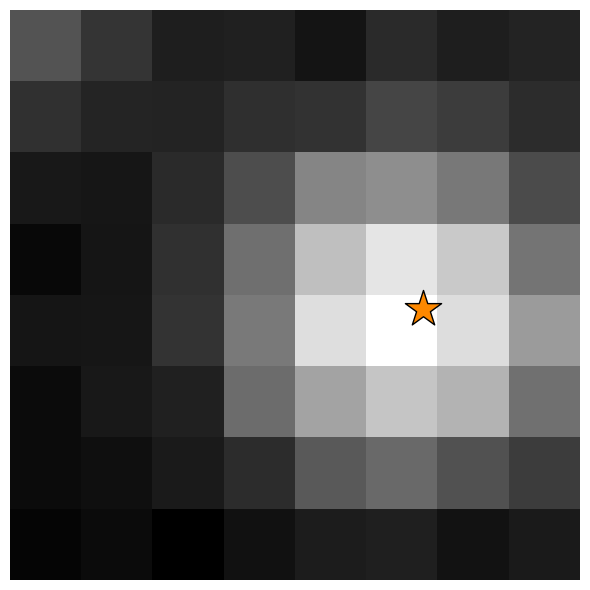

In [64]:
# one star

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

sample_locs = torch.tensor([[4.2,5.8]]).cpu()
sample_fluxes = torch.tensor([28.0]).cpu()

_ = ax.imshow(example_tile.arcsinh().cpu(), cmap = 'gray')
flux = ax.scatter(sample_locs[:,1] - 0.5, sample_locs[:,0] - 0.5, c = sample_fluxes, cmap = 'Wistia', s = 750, marker = '*', edgecolors = 'black', vmin = 0, vmax = 30)
_ = ax.set_xticks([])
_ = ax.set_yticks([])
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

_ = fig.tight_layout()

fig.savefig('results/figures/example_tile_sample5.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

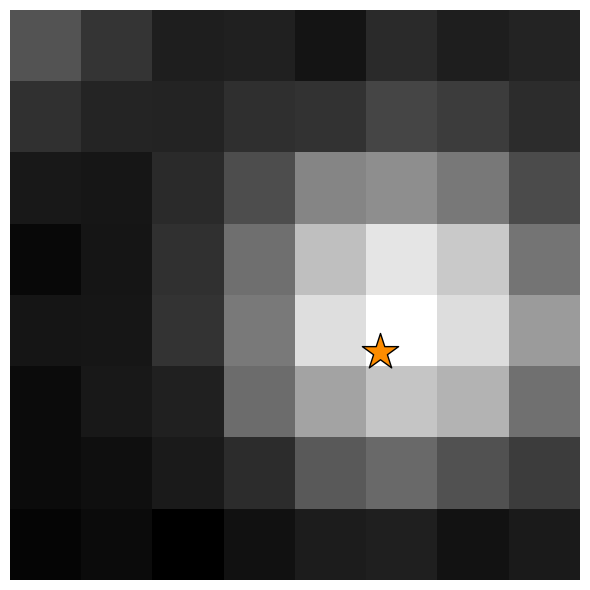

In [65]:
# one star

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

sample_locs = torch.tensor([[4.8,5.2]]).cpu()
sample_fluxes = torch.tensor([27.0]).cpu()

_ = ax.imshow(example_tile.arcsinh().cpu(), cmap = 'gray')
flux = ax.scatter(sample_locs[:,1] - 0.5, sample_locs[:,0] - 0.5, c = sample_fluxes, cmap = 'Wistia', s = 750, marker = '*', edgecolors = 'black', vmin = 0, vmax = 30)
_ = ax.set_xticks([])
_ = ax.set_yticks([])
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)

_ = fig.tight_layout()

fig.savefig('results/figures/example_tile_sample6.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

---